In [ ]:
import os
import json
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

import xgboost as xgb

import shap

# Kaggle Dataset

## Description
- Participant ID: Unique identifier for each participant in the study.

- Age: The age of the participant (in years), which can influence metabolism and weight change.

- Gender: Gender of the participant (M/F), as physiological differences may affect weight management.

- Current Weight (lbs): The participant's weight at the beginning of the study, serving as a baseline for weight change.

- BMR (Calories): Basal Metabolic Rate, calculated using the Mifflin-St Jeor equation, representing the number of calories burned at rest.

- Daily Calories Consumed: Total caloric intake per day, including variability to reflect real-world eating habits.

- Daily Caloric Surplus/Deficit: The difference between calories consumed and BMR, indicating whether the participant is in a caloric surplus or deficit.

- Weight Change (lbs): The estimated change in weight over a specified duration, based on caloric surplus/deficit.

- Duration (weeks): The time period over which weight change is measured, ranging from 1 to 12 weeks.

- Physical Activity Level: Self-reported level of physical activity, categorized as Sedentary, Lightly Active, Moderately Active, or Very Active.

- Macronutrient Breakdown: Composition of the participant's diet, expressed as percentages of carbohydrates, proteins, and fats.

- Sleep Quality: Self-reported quality of sleep, categorized as Poor, Fair, Good, or Excellent, which can affect weight management.

- Stress Level: A numerical score (1-10) indicating the participant's perceived stress level, as stress can influence eating behaviors and weight.

In [51]:
EXTRACT_PATH = "weightloss_data"
ZIP_PATH = "comprehensive-weight-change-prediction.zip"
DATA_FILE = "weight_change_dataset.csv"
os.makedirs(EXTRACT_PATH, exist_ok=True)


if not os.path.exists(f"{EXTRACT_PATH}\{DATA_FILE}"):
    import kaggle
    with open('kaggle.json', "r") as file:
        config = json.load(file)

    os.environ['KAGGLE_USERNAME'] = config["username"]
    os.environ['KAGGLE_KEY'] = config["key"]

    !kaggle datasets download -d abdullah0a/comprehensive-weight-change-prediction
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
else:
    print("Data exists locally, will not re-download")

Data exists locally, will not re-download


# Pandas

## Read from CSV

In [52]:
df = pd.read_csv(f"{EXTRACT_PATH}/{DATA_FILE}")
df.head()

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.2,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.4,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.4,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.8,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.0,10,Lightly Active,Good,1,157.5


## Dataframe info

In [53]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Participant ID                 100 non-null    int64  
 1   Age                            100 non-null    int64  
 2   Gender                         100 non-null    object 
 3   Current Weight (lbs)           100 non-null    float64
 4   BMR (Calories)                 100 non-null    float64
 5   Daily Calories Consumed        100 non-null    float64
 6   Daily Caloric Surplus/Deficit  100 non-null    float64
 7   Weight Change (lbs)            100 non-null    float64
 8   Duration (weeks)               100 non-null    int64  
 9   Physical Activity Level        100 non-null    object 
 10  Sleep Quality                  100 non-null    object 
 11  Stress Level                   100 non-null    int64  
 12  Final Weight (lbs)             100 non-null    floa

,Participant ID,Age,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Stress Level,Final Weight (lbs)
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,37.910000,171.533000,2518.206000,3518.292000,1000.091000,-2.779817,6.920000,4.810000,168.750000
std,29.011492,12.219454,30.333856,364.431221,513.313097,371.560827,7.443719,3.515277,2.576879,30.588004
min,1.000000,18.000000,100.000000,1566.500000,2030.900000,82.500000,-35.678115,1.000000,1.000000,98.200000
25%,25.750000,26.750000,153.650000,2255.050000,3233.300000,766.950000,-5.012312,4.000000,2.750000,149.550000
50%,50.500000,38.000000,172.150000,2519.500000,3636.050000,1013.100000,0.100000,7.000000,5.000000,169.800000
75%,75.250000,46.250000,192.475000,2805.975000,4000.000000,1253.325000,1.850000,10.000000,7.000000,188.300000
max,100.000000,59.000000,238.200000,3390.800000,4000.000000,1922.500000,5.000000,12.000000,9.000000,232.500000


In [54]:
cols_to_drop = ['Participant ID']
list_to_rename = {'Age':'age',
                  'Gender': 'gender',
                  'Current Weight (lbs)': 'starting_weight',
                  'BMR (Calories)': 'BMR',
                  'Daily Calories Consumed': 'calorie_intake',
                  'Daily Caloric Surplus/Deficit': 'calorie_surplus',
                  'Weight Change (lbs)' : 'net_weight_change',
                  'Duration (weeks)': 'num_weeks',
                  'Stress Level' : 'stress_lvl',
                  'Final Weight (lbs)' : 'final_weight',
                  'Physical Activity Level' : 'physical_lvl',
                  'Sleep Quality': 'sleep_quality'
                  }

df = df.drop(cols_to_drop, axis=1)
df = df.rename(columns=list_to_rename)

print(df.columns.tolist())
df.to_csv(f"{EXTRACT_PATH}/weight_change_dataset_cleaned.csv", index=False)

['age', 'gender', 'starting_weight', 'BMR', 'calorie_intake', 'calorie_surplus', 'net_weight_change', 'num_weeks', 'physical_lvl', 'sleep_quality', 'stress_lvl', 'final_weight']


In [55]:
def df_unique_values(df, MAX_VALUES=10, col=None):

    print("\n================== UNIQUE VALUES REPORT ==================\n")

    if col is not None:
        if col not in df.columns:
            print(f"Column '{col}' does not exist in the DataFrame.")
            return
        
        unique_vals = df[col].unique()
        num_unique = len(unique_vals)

        print(f"Column Name: {col}")

        if num_unique > MAX_VALUES:
            print(f"  Unique Values ({num_unique} total): showing first {MAX_VALUES}")
            print(f"  {list(unique_vals[:MAX_VALUES])}")
        else:
            print(f"  Unique Values ({num_unique} total):")
            print(f"  {unique_vals}")

        print("\n  Value Counts:")
        print(df[col].value_counts().head(MAX_VALUES))

        print("\n====================== END REPORT ======================\n")
        return
    
    for col in df.columns:
        print(f"Column Name: {col}")
        unique_vals = df[col].unique()
        num_unique = len(unique_vals)

        if num_unique > MAX_VALUES:
            print(f"  Unique Values ({num_unique} total): showing first {MAX_VALUES}")
            print(f"  {list(unique_vals[:MAX_VALUES])}")
        else:
            print(f"  Unique Values ({num_unique} total):")
            print(f"  {unique_vals}")

        print("\n  Value Counts:")
        print(df[col].value_counts().head(MAX_VALUES))
        print("\n--------------------------------------------------------------\n")

    print("========================== END REPORT =========================\n")

## Age Distribution

Median Age: Half the people are younger, half are older than ~37-38
Box: 50% of the data fall between 27 and 45
Max age: ~60 years old
Min age: ~18 years old
No outliers

Values from Boxplot for age
Min: 18
Q1: 26.75
Median: 38.0
Q3: 46.25
Max: 59


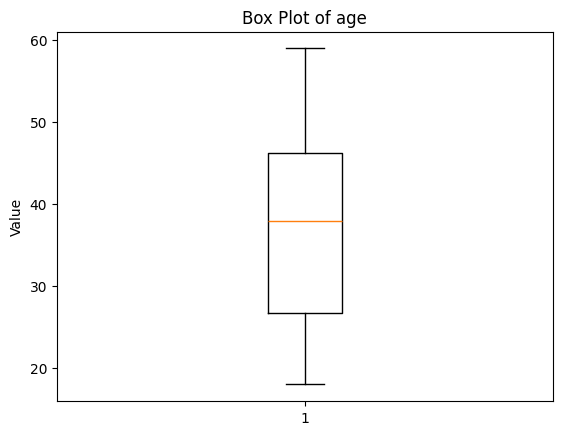

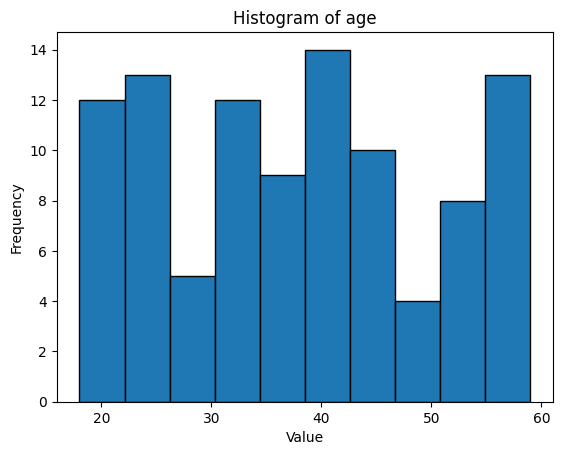

Values from Boxplot for num_weeks
Min: 1
Q1: 4.0
Median: 7.0
Q3: 10.0
Max: 12


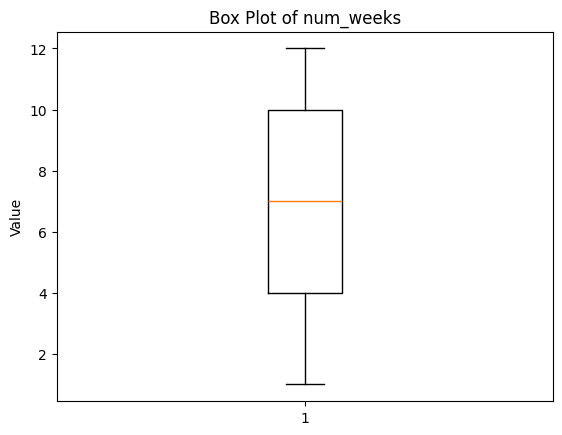

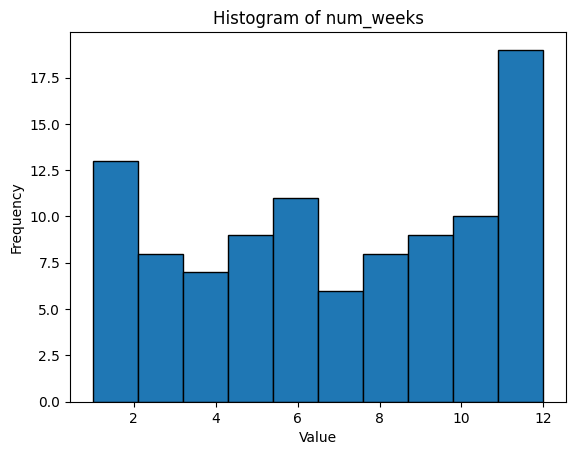

In [56]:
def plot_histogram(df, value, bins=10, TITLE ="Histogram of", XLABEL = "Value", YLABEL = "Frequency"):
    plt.hist(df[value], bins=bins, edgecolor = 'black')
    plt.title(TITLE + " " + value)
    plt.xlabel(XLABEL)
    plt.ylabel(YLABEL)
    plt.show()


def boxplot_values(df, value):
    target = df[value]
    minimum = target.min()
    q1 = target.quantile(0.25)
    median = target.median()
    q3 = target.quantile(0.75)
    maximum = target.max()

    print(f"Values from Boxplot for {value}")
    print("Min:", minimum)
    print("Q1:", q1)
    print("Median:", median)
    print("Q3:", q3)
    print("Max:", maximum)


def plot_boxplot(df, value, TITLE="Box Plot of", YLABEL="Value"):
    boxplot_values(df, value)
    plt.boxplot(df[value], vert=True)
    plt.title(TITLE + " " + value)
    plt.ylabel(YLABEL)
    plt.show()

plot_boxplot(df, "age")
plot_histogram(df, "age")

plot_boxplot(df, "num_weeks")
plot_histogram(df, "num_weeks")


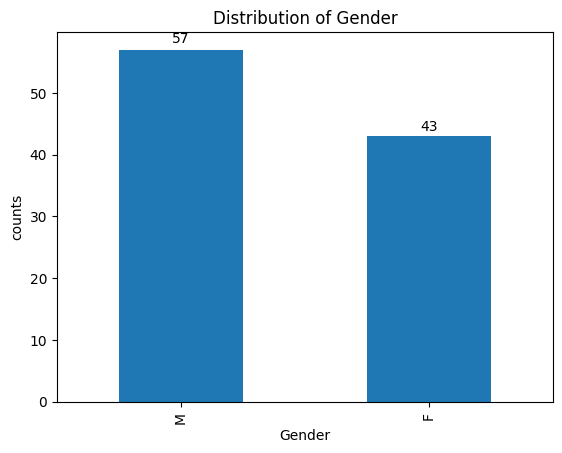

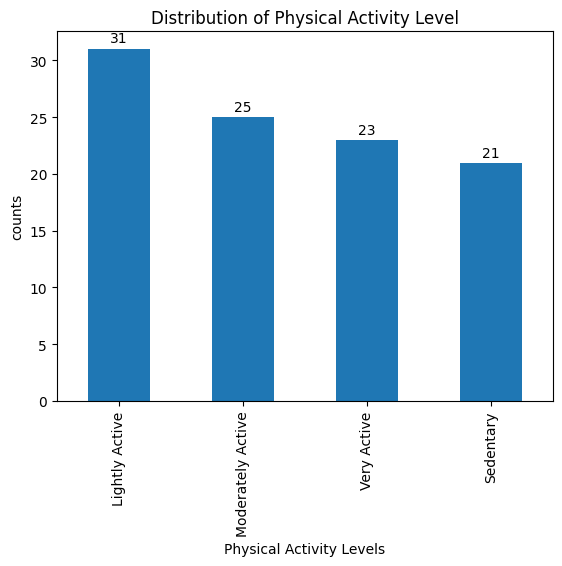

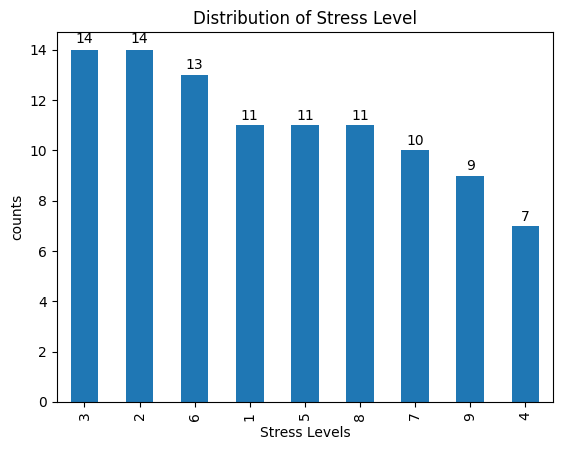

In [57]:
def plot_distribution(df, col = None, x_label = "x_label", y_label = "y_label", title = "title", display_counts = True):
    counts = df[col].value_counts()

    plt.figure()
    ax = counts.plot(kind="bar")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    if display_counts:
        # Add counts on bars
        for i, v in enumerate(counts.values):
            ax.text(i, v + (0.01 * v), str(v), ha='center', va='bottom')

    plt.show()


plot_distribution(df, "gender", x_label= "Gender", y_label= "counts", title= "Distribution of Gender")
plot_distribution(df, "physical_lvl", x_label= "Physical Activity Levels", y_label= "counts", title= "Distribution of Physical Activity Level")
plot_distribution(df, "stress_lvl", x_label= "Stress Levels", y_label= "counts", title= "Distribution of Stress Level")

Number of missing rows per column
age                  0
gender               0
starting_weight      0
BMR                  0
calorie_intake       0
calorie_surplus      0
net_weight_change    0
num_weeks            0
physical_lvl         0
sleep_quality        0
stress_lvl           0
final_weight         0
dtype: int64


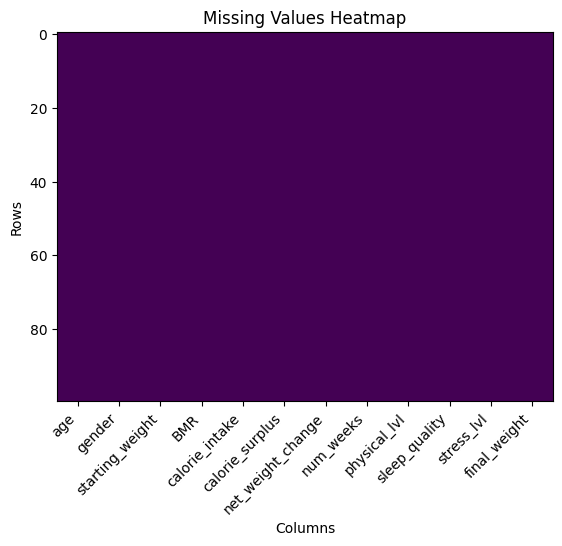

In [58]:
def plot_missing_values(df, TITLE = "Missing Values Heatmap", XLABEL = 'Columns', YLABEL = 'Rows'):
    print("Number of missing rows per column")
    print(df.isnull().sum())
    plt.figure()
    plt.imshow(df.isnull(), cmap='viridis', aspect='auto')
    plt.title(TITLE)
    plt.xlabel(XLABEL)
    plt.ylabel(YLABEL)
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=45, ha='right')
    plt.show()

plot_missing_values(df)


In [59]:
df_unique_values(df, col="physical_lvl")
df_unique_values(df, col="stress_lvl")
df_unique_values(df, col="sleep_quality")


================== UNIQUE VALUES REPORT ==================

Column Name: physical_lvl
  Unique Values (4 total):
  ['Sedentary' 'Very Active' 'Lightly Active' 'Moderately Active']

  Value Counts:
physical_lvl
Lightly Active       31
Moderately Active    25
Very Active          23
Sedentary            21
Name: count, dtype: int64

====================== END REPORT ======================


================== UNIQUE VALUES REPORT ==================

Column Name: stress_lvl
  Unique Values (9 total):
  [6 3 2 1 5 9 7 4 8]

  Value Counts:
stress_lvl
3    14
2    14
6    13
1    11
5    11
8    11
7    10
9     9
4     7
Name: count, dtype: int64

====================== END REPORT ======================


================== UNIQUE VALUES REPORT ==================

Column Name: sleep_quality
  Unique Values (4 total):
  ['Excellent' 'Good' 'Fair' 'Poor']

  Value Counts:
sleep_quality
Poor         38
Fair         24
Good         22
Excellent    16
Name: count, dtype: int64

===============

In [60]:
ordinal_categories_physical_lvl = [['Sedentary', 'Lightly Active', 'Moderately Active', 'Very Active']]
ordinal_categories_sleep_quality = [['Poor', 'Fair', 'Good', 'Excellent']]

def ordinal_encoder(categories, target_col, new_col):
    encoder = OrdinalEncoder(categories=categories)
    df[new_col] = encoder.fit_transform(df[[target_col]])
    return df


df = ordinal_encoder(ordinal_categories_physical_lvl, 'physical_lvl', 'physical_lvl_encoded')
df = ordinal_encoder(ordinal_categories_sleep_quality, 'sleep_quality', 'sleep_quality_encoded')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    100 non-null    int64  
 1   gender                 100 non-null    object 
 2   starting_weight        100 non-null    float64
 3   BMR                    100 non-null    float64
 4   calorie_intake         100 non-null    float64
 5   calorie_surplus        100 non-null    float64
 6   net_weight_change      100 non-null    float64
 7   num_weeks              100 non-null    int64  
 8   physical_lvl           100 non-null    object 
 9   sleep_quality          100 non-null    object 
 10  stress_lvl             100 non-null    int64  
 11  final_weight           100 non-null    float64
 12  physical_lvl_encoded   100 non-null    float64
 13  sleep_quality_encoded  100 non-null    float64
dtypes: float64(8), int64(3), object(3)
memory usage: 11.1+ KB


In [61]:

df = df.drop('net_weight_change', axis = 1)
df = df.drop('physical_lvl', axis = 1)
df = df.drop('sleep_quality', axis = 1)

def one_hot_encode_gender(df, column="gender"):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop(columns=[column]), dummies], axis=1)
    return df

df = one_hot_encode_gender(df, column="gender")

In [62]:
df.to_csv('Dataset_to_train.csv', index=False)

In [63]:
y = df["final_weight"]
X = df.drop(columns=["final_weight"])

In [64]:
TEST_SIZE = 0.25
TRAIN_SIZE = 1 - TEST_SIZE

print(f"Training Size: {TRAIN_SIZE}")
print(f"Testing Size: {TEST_SIZE}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)


Training Size: 0.75
Testing Size: 0.25


In [65]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

    return model, rmse, r2



def run_grid_search(model, param_grid, X_train, y_train, cv=3):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    return grid_search.best_estimator_

In [66]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Run grid search
best_model = run_grid_search(model, param_grid, X_train, y_train)

# Evaluate baseline model
my_model, my_rmse, my_r2 = evaluate_model(model, X_train, X_test, y_train, y_test)

# Evaluate tuned model
new_model, new_rmse, new_r2 = evaluate_model(best_model, X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.8}
RMSE: 6.815
R²: 0.941
RMSE: 5.804
R²: 0.957


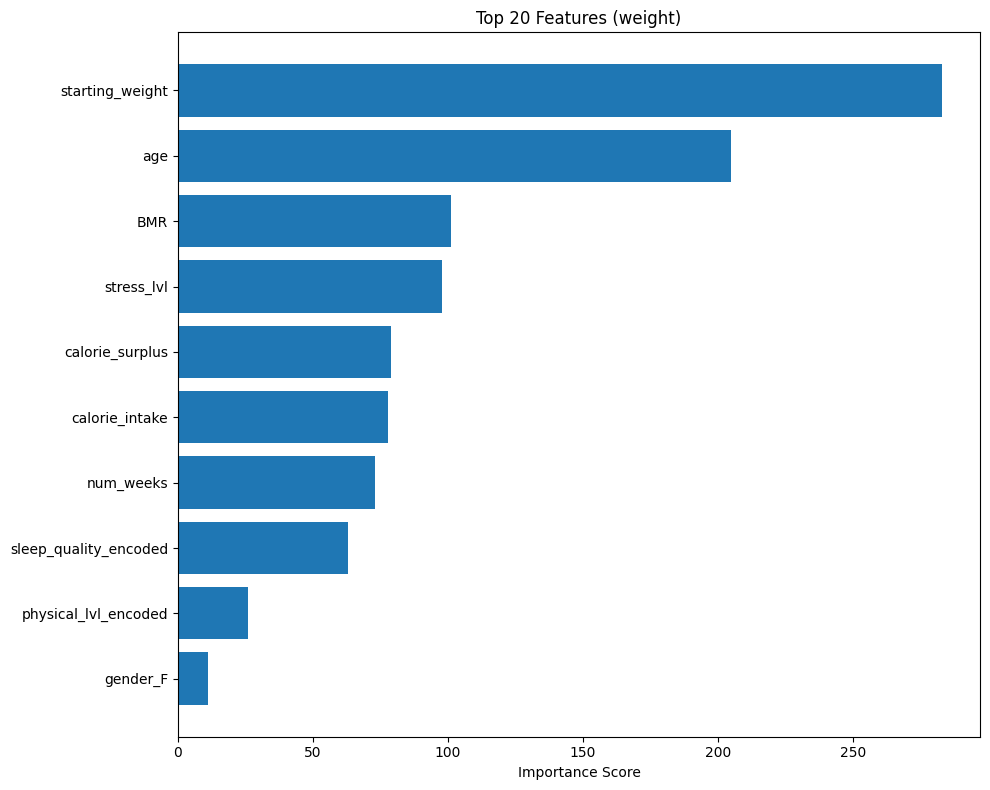

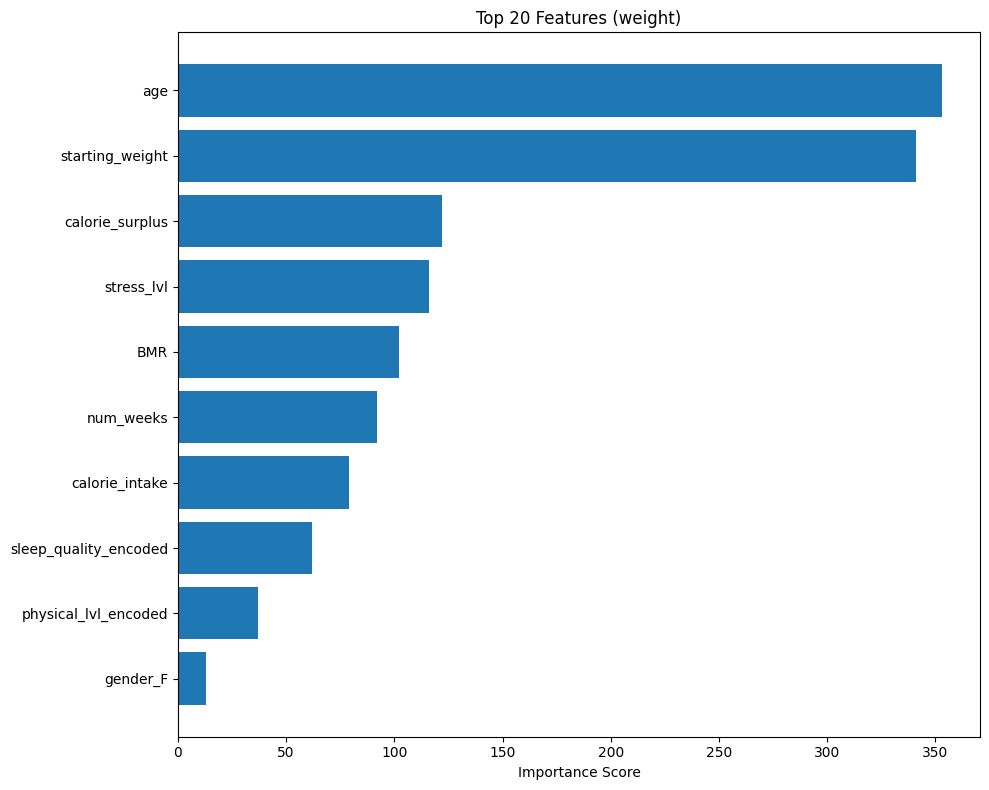

In [67]:
def plot_feature_importance(model, top_n=20, importance_type="weight"):

    booster = model.get_booster()
    importance = booster.get_score(importance_type=importance_type)

    importance_df = (
        pd.DataFrame({
            "Feature": list(importance.keys()),
            "Importance": list(importance.values())
        })
        .sort_values("Importance", ascending=False)
    )

    plt.figure(figsize=(10, 8))
    plt.barh(
        importance_df["Feature"].head(top_n)[::-1],
        importance_df["Importance"].head(top_n)[::-1]
    )
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_n} Features ({importance_type})")
    plt.tight_layout()
    plt.show()

    return importance_df

my_importance_df = plot_feature_importance(my_model, top_n=20)
new_importance_df = plot_feature_importance(new_model, top_n=20)


In [68]:
def plot_shap_summary(model, X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


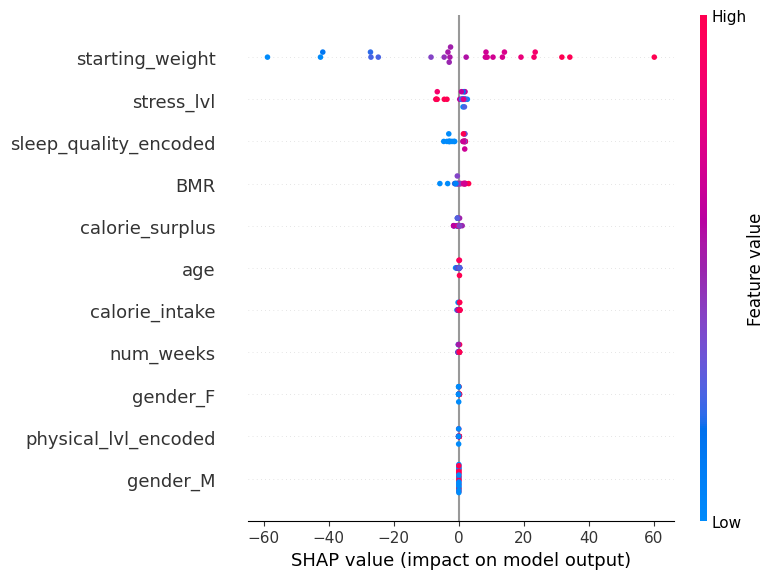

In [69]:
plot_shap_summary(my_model, X_test)

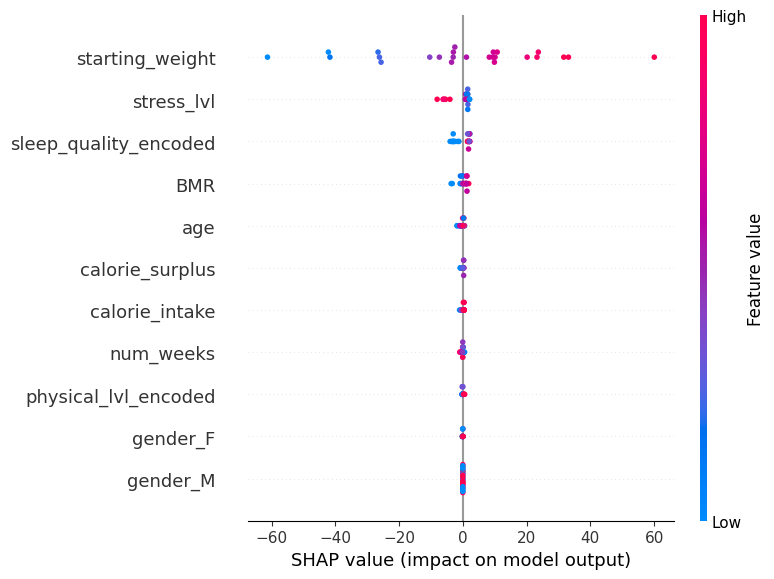

In [70]:
plot_shap_summary(best_model, X_test)
